Домашку будет легче делать в колабе (убедитесь, что у вас runtype с gpu).

# Задание 1 (3 балла)

Обучите word2vec модели с негативным семплированием (cbow и skip-gram) аналогично тому, как это было сделано в семинаре. Вам нужно изменить следующие пункты: 
1) добавьте лемматизацию в предобработку (любым способом)  
2) измените размер окна в большую или меньшую сторону
3) измените размерность итоговых векторов

Выберете несколько не похожих по смыслу слов (не таких как в семинаре), и протестируйте полученные эмбединги (найдите ближайшие слова и оцените качество, как в семинаре). 
Постарайтесь обучать модели как можно дольше и на как можно большем количестве данных. (Но если у вас мало времени или ресурсов, то допустимо взять поменьше данных и поставить меньше эпох)

### Перенос и адаптация кода из лекции

In [9]:
# import tensorflow as tf
import numpy as np
import pandas as pd
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances

from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline

In [10]:
import os
os.environ["KERAS_BACKEND"] = "torch"
# os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import torch
# torch.set_default_device('cpu')

import keras
print(keras.__version__)

3.8.0


In [11]:
import re

In [7]:
class Vocab:

    def __init__(self, corpus_path:str):

        with open(corpus_path) as file:
            texts = file.read().split('\n')

        vocab = Counter()

        for text in texts:
            vocab.update(self.preprocess(text))

        filtered_vocab = set()

        for word in vocab:
            if vocab[word] > 30:
                filtered_vocab.add(word)

        self.word2id = {'PAD':0}

        for word in filtered_vocab:
            self.word2id[word] = len(self.word2id)

        self.id2word = {i:word for word, i in self.word2id.items()}

        self.train_sentences = []

        for text in texts:
            tokens = self.preprocess(text)
            if not tokens:
                continue
            ids = [self.word2id[token] for token in tokens if token in self.word2id]
            self.train_sentences.append(ids)

    def preprocess(self, text:str) -> list[str]:
        tokens = re.sub('#+', ' ', text.lower()).split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return tokens

In [50]:
wiki = Vocab(r"./data/wiki_data.txt")

In [51]:
def most_similar(word, vocab:Vocab, embeddings):
    similar = [vocab.id2word[i] for i in 
               cosine_distances(embeddings[vocab.word2id[word]].reshape(1, -1), embeddings).argsort()[0][:10]]
    return similar

In [52]:
# skip gram
def gen_batches_sg(vocab:Vocab, window = 5, batch_size=1000):
    
    # параметр window задает его целиком
    # нам нужно поделить его пополам на левую и правую часть
    # когда делится неровно, то левая часть больше на 1
    left_context_length = (window/2).__ceil__() # округлить в большую сторону
    right_context_length = window // 2 # округлить в меньшую сторону

    vocab_size = len(vocab.id2word)
    
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in vocab.train_sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-left_context_length):i] + sent[i+1:i+right_context_length]
                for context_word in context:
                    X_target.append(word)
                    X_context.append(context_word)
                    y.append(1)
                    
                    X_target.append(word)
                    X_context.append(np.random.randint(vocab_size))
                    y.append(0)
                    
                    if len(X_target) >= batch_size:
                        X_target = np.array(X_target)
                        X_context = np.array(X_context)
                        y = np.array(y)
                        yield ((X_target, X_context), y)
                        X_target = []
                        X_context = []
                        y = []

In [53]:

def gen_batches_cbow(vocab:Vocab, window = 5, batch_size=1000):
    
    # параметр window задает его целиком
    # нам нужно поделить его пополам на левую и правую часть
    # когда делится неровно, то левая часть больше на 1
    left_context_length = (window/2).__ceil__() # округлить в большую сторону
    right_context_length = window // 2 # округлить в меньшую сторону

    vocab_size = len(vocab.id2word)
    
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in vocab.train_sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-left_context_length):i] + sent[i+1:i+right_context_length]

                X_target.append(word)
                X_context.append(context)
                y.append(1)
                
                X_target.append(np.random.randint(vocab_size))
                X_context.append(context)
                y.append(0)

                if len(X_target) == batch_size:
                    X_target = np.array(X_target)
                    X_context = keras.preprocessing.sequence.pad_sequences(X_context, maxlen=window)
                    y = np.array(y)
                    yield ((X_target, X_context), y)
                    X_target = []
                    X_context = []
                    y = []

### А дальше будет "эталонное" использование классов как неймспейсов

А я сначала пытался сделать нормально, с наследованием и красиво, но постоянно получал на буквально том же коде, что и в лекции, такую ошибку:

  <img
    src="./data/cuda.png"
    alt="Посетить сайт MDN"
    sizes="(max-width: 600px) 200px, 50vw"
 />

#### Вариант 1: Skipgram dim 200; window 3; 2000 steps

In [54]:
class StockSkipgramW2VwNS:
    inputs_target = keras.layers.Input(shape=(1,))
    inputs_context = keras.layers.Input(shape=(1,))

    
    embeddings_target = keras.layers.Embedding(input_dim=len(wiki.word2id), output_dim=200)(inputs_target, )
    embeddings_context = keras.layers.Embedding(input_dim=len(wiki.word2id), output_dim=200)(inputs_context, )

    target = keras.layers.Flatten()(embeddings_target)
    context = keras.layers.Flatten()(embeddings_context)

    dot = keras.layers.Dot(1)([target, context])
    outputs = keras.layers.Activation(activation='sigmoid')(dot)

    model = keras.Model(inputs=[inputs_target, inputs_context], 
                        outputs=outputs)
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])
    
    model.build((None, 10))

In [55]:
StockSkipgramW2VwNS.model.fit(gen_batches_sg(wiki, window=3),
          validation_data=gen_batches_sg(wiki,  window=3),
          batch_size=1000,
          steps_per_epoch=2000,
          validation_steps=30,
          epochs=20)

Epoch 1/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.6974 - loss: 0.5803 - val_accuracy: 0.7812 - val_loss: 0.4671
Epoch 2/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.7911 - loss: 0.4528 - val_accuracy: 0.8071 - val_loss: 0.4278
Epoch 3/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.8015 - loss: 0.4338 - val_accuracy: 0.8164 - val_loss: 0.4059
Epoch 4/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.8100 - loss: 0.4216 - val_accuracy: 0.8196 - val_loss: 0.4034
Epoch 5/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.8139 - loss: 0.4137 - val_accuracy: 0.8411 - val_loss: 0.3625
Epoch 6/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.8221 - loss: 0.3985 - val_accuracy: 0.8201 - val_loss: 0.3980
Epoch 7/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.8269 - loss: 0.3900 - val_accuracy: 0.8235 - val_loss: 0.3917
Epoch 8/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.8283 - loss: 

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


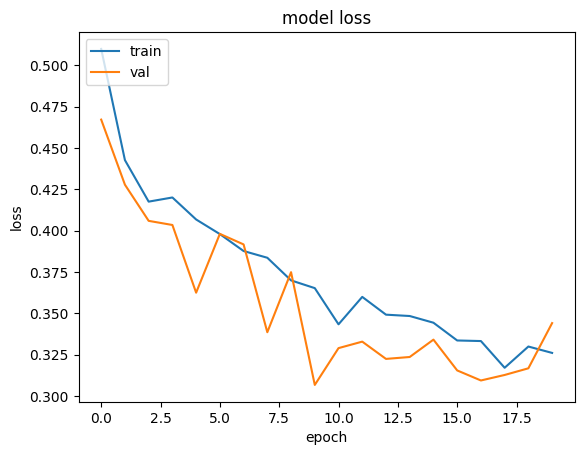

In [57]:
print(StockSkipgramW2VwNS.model.history.history.keys())
# summarize history for accuracy
plt.plot(StockSkipgramW2VwNS.model.history.history['loss'])
plt.plot(StockSkipgramW2VwNS.model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [58]:
embeddings = StockSkipgramW2VwNS.model.layers[2].get_weights()[0]

In [59]:
most_similar('любовь', wiki, embeddings)

['любовь',
 'знаю',
 'благодарность',
 'узнает',
 'картину',
 'славу',
 'невесты',
 'салли',
 'проявлять',
 'моя']

In [60]:
most_similar('стена', wiki, embeddings)

['стена',
 'каменная',
 'печь',
 'балка',
 'колония',
 'гостиница',
 'небольшая',
 'инфраструктура',
 'зелёная',
 'горная']

#### #### Вариант 2: CBOW dim 400; window 6; 2000 steps

In [61]:
class StockCbowW2VwNS:
    #cbow negative sampling
    inputs_target = keras.layers.Input(shape=(1,))
    inputs_context = keras.layers.Input(shape=(6,))


    embeddings_target = keras.layers.Embedding(input_dim=len(wiki.word2id), output_dim=300)(inputs_target, )
    embeddings_context = keras.layers.Embedding(input_dim=len(wiki.word2id), output_dim=300)(inputs_context, )

    target = keras.layers.Flatten()(embeddings_target)
    context = keras.layers.Lambda(lambda x: x.sum(axis=1))(embeddings_context)
    dot = keras.layers.Dot(1)([target, context])

    # полученную близость нужно преобразовать в вероятность
    # когда она одна используется не софтмакс и сигмоида
    outputs = keras.layers.Activation(activation='sigmoid')(dot)

    model = keras.Model(inputs=[inputs_target, inputs_context], 
                        outputs=outputs)


    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])
    model.build([(None, 1), (None, 6)])


In [62]:
StockCbowW2VwNS.model.fit(gen_batches_cbow(wiki, window=6),
          validation_data=gen_batches_cbow(wiki,  window=6),
          batch_size=1000,
          steps_per_epoch=2000,
          validation_steps=30,
          epochs=20)

Epoch 1/20


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 27s 13ms/step - accuracy: 0.7643 - loss: 0.4873 - val_accuracy: 0.8385 - val_loss: 0.3730
Epoch 2/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 28s 14ms/step - accuracy: 0.8413 - loss: 0.3638 - val_accuracy: 0.8722 - val_loss: 0.3088
Epoch 3/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 27s 13ms/step - accuracy: 0.8630 - loss: 0.3228 - val_accuracy: 0.8883 - val_loss: 0.2700
Epoch 4/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - accuracy: 0.8804 - loss: 0.2866 - val_accuracy: 0.9327 - val_loss: 0.1963
Epoch 5/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 28s 14ms/step - accuracy: 0.8977 - loss: 0.2478 - val_accuracy: 0.9203 - val_loss: 0.2050
Epoch 6/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 29s 14ms/step - accuracy: 0.9073 - loss: 0.2256 - val_accuracy: 0.9241 - val_loss: 0.1927
Epoch 7/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 26s 13ms/step - accuracy: 0.9114 - loss: 0.2179 - val_accuracy: 0.9264 - val_loss: 0.1906
Epoch 8/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - accuracy: 0.9179 - loss: 0.20

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


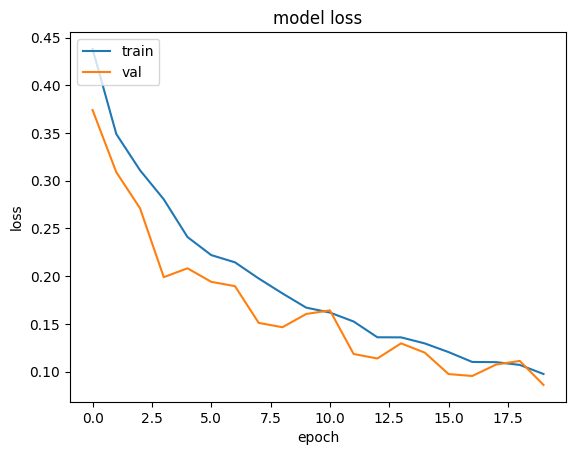

In [60]:
print(StockCbowW2VwNS.model.history.history.keys())
# summarize history for accuracy
plt.plot(StockCbowW2VwNS.model.history.history['loss'])
plt.plot(StockCbowW2VwNS.model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [63]:
embeddings = StockCbowW2VwNS.model.layers[2].get_weights()[0]

In [64]:
most_similar('любовь', wiki, embeddings)

['любовь',
 'близка',
 'уважение',
 'сердце',
 'восходит',
 'внучка',
 'изабелла',
 'восприятие',
 '«любовь',
 'любви']

In [65]:
most_similar('стена', wiki, embeddings)

['стена',
 'изменена',
 'разрушена',
 'PAD',
 'платформенные',
 'проложена',
 'возведена',
 'приписана',
 'найдена',
 'крыша']

#### А теперь обучим такие же модели, но добавим лемматизацию в препроц

In [62]:
!pip install pymorphy3

  Using cached DAWG_Python-0.7.2-py2.py3-none-any.whl.metadata (7.0 kB)
Using cached DAWG_Python-0.7.2-py2.py3-none-any.whl (11 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 28.1 MB/s eta 0:00:00a 0:00:01


In [81]:
import pymorphy3 as pm
from functools import lru_cache

In [82]:
class LemmatizedVocab(Vocab):

    morph = pm.MorphAnalyzer()
    
    def __init__(self, corpus_path):
        self.itercounter = 0
        self.totalcounter = 0
        super().__init__(corpus_path)

    @lru_cache(maxsize=30000)
    def lemmatize(self, word:str) -> str:
        return self.morph.parse(word)[0].normal_form

    def preprocess(self, text:str) -> list[str]:
        self.itercounter += 1
        if self.itercounter == 1000:
            self.itercounter = 0
            self.totalcounter += 1000
            print(f"{self.totalcounter}/20000")
            
        tokens = super().preprocess(text)
        tokens = [self.lemmatize(tok) for tok in tokens]
        return tokens

In [13]:
lwiki = LemmatizedVocab(r"data/wiki_data.txt")

1000/20000
2000/20000
3000/20000
4000/20000
5000/20000
6000/20000
7000/20000
8000/20000
9000/20000
10000/20000
11000/20000
12000/20000
13000/20000
14000/20000
15000/20000
16000/20000
17000/20000
18000/20000
19000/20000
20000/20000
21000/20000
22000/20000
23000/20000
24000/20000
25000/20000
26000/20000
27000/20000
28000/20000
29000/20000
30000/20000
31000/20000
32000/20000
33000/20000
34000/20000
35000/20000
36000/20000
37000/20000
38000/20000
39000/20000
40000/20000


In [15]:
len(lwiki.word2id)

12461

In [16]:
class LemmatizedSkipgramW2VwNS:
    inputs_target = keras.layers.Input(shape=(1,))
    inputs_context = keras.layers.Input(shape=(1,))

    
    embeddings_target = keras.layers.Embedding(input_dim=len(lwiki.word2id), output_dim=200)(inputs_target, )
    embeddings_context = keras.layers.Embedding(input_dim=len(lwiki.word2id), output_dim=200)(inputs_context, )

    target = keras.layers.Flatten()(embeddings_target)
    context = keras.layers.Flatten()(embeddings_context)

    dot = keras.layers.Dot(1)([target, context])
    outputs = keras.layers.Activation(activation='sigmoid')(dot)

    model = keras.Model(inputs=[inputs_target, inputs_context], 
                        outputs=outputs)
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])
    
    model.build((None, 3))

In [20]:
LemmatizedSkipgramW2VwNS.model.fit(gen_batches_sg(lwiki, window=3),
          validation_data=gen_batches_sg(lwiki,  window=3),
          batch_size=1000,
          steps_per_epoch=2000,
          
          validation_steps=30,
          epochs=20)

Epoch 1/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.7249 - loss: 0.5566 - val_accuracy: 0.7990 - val_loss: 0.4519
Epoch 2/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.8126 - loss: 0.4257 - val_accuracy: 0.8270 - val_loss: 0.3978
Epoch 3/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8243 - loss: 0.4026 - val_accuracy: 0.8407 - val_loss: 0.3691
Epoch 4/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8353 - loss: 0.3817 - val_accuracy: 0.8250 - val_loss: 0.4022
Epoch 5/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.8289 - loss: 0.3955 - val_accuracy: 0.8497 - val_loss: 0.3589
Epoch 6/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8340 - loss: 0.3850 - val_accuracy: 0.8487 - val_loss: 0.3537
Epoch 7/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8404 - loss: 0.3716 - val_accuracy: 0.8496 - val_loss: 0.3518
Epoch 8/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8399 - loss: 0

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


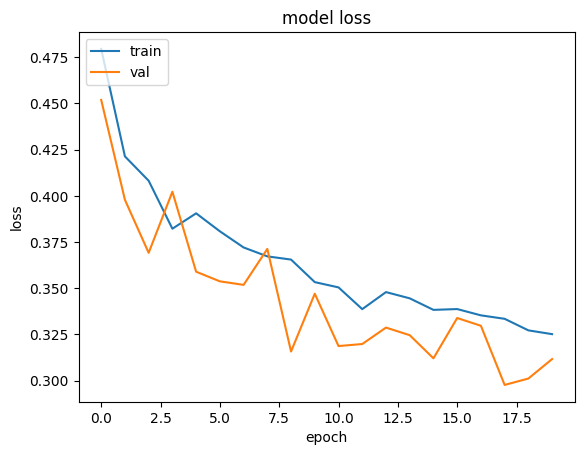

In [27]:
print(LemmatizedSkipgramW2VwNS.model.history.history.keys())
# summarize history for accuracy
plt.plot(LemmatizedSkipgramW2VwNS.model.history.history['loss'])
plt.plot(LemmatizedSkipgramW2VwNS.model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [46]:
embeddings = LemmatizedSkipgramW2VwNS.model.layers[2].get_weights()[0]

In [47]:
most_similar('любовь', lwiki, embeddings)

['любовь',
 'красота',
 'уважение',
 'истина',
 'справедливость',
 'верность',
 'вера',
 'мама',
 'жизни»',
 'мой']

In [48]:
most_similar('стена', lwiki, embeddings)

['стена',
 'башня',
 'фасад',
 'ограда',
 'купол',
 'кирпичный',
 'деревянный',
 'каменный',
 'колокольня',
 'кровля']

#### Только тут добавим шагов

А еще на этом этапе я понял, что ошибка Куды возникает не по какой-то конкретно причине, а когда самой Куде заблагорассудится

In [28]:
class LemmatizedCbowW2VwNS:
    #cbow negative sampling
    inputs_target = keras.layers.Input(shape=(1,))
    inputs_context = keras.layers.Input(shape=(6,))


    embeddings_target = keras.layers.Embedding(input_dim=len(lwiki.word2id), output_dim=300)(inputs_target, )
    embeddings_context = keras.layers.Embedding(input_dim=len(lwiki.word2id), output_dim=300)(inputs_context, )

    target = keras.layers.Flatten()(embeddings_target)
    context = keras.layers.Lambda(lambda x: x.sum(axis=1))(embeddings_context)
    dot = keras.layers.Dot(1)([target, context])

    # полученную близость нужно преобразовать в вероятность
    # когда она одна используется не софтмакс и сигмоида
    outputs = keras.layers.Activation(activation='sigmoid')(dot)

    model = keras.Model(inputs=[inputs_target, inputs_context], 
                        outputs=outputs)


    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])
    model.build([(None, 1), (None, 6)])


In [29]:
LemmatizedCbowW2VwNS.model.fit(gen_batches_cbow(lwiki, window=6),
          validation_data=gen_batches_cbow(lwiki,  window=6),
          batch_size=1000,
          steps_per_epoch=7000,
          validation_steps=30,
          epochs=20)

Epoch 1/20
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 70s 10ms/step - accuracy: 0.8244 - loss: 0.3985 - val_accuracy: 0.8895 - val_loss: 0.2717
Epoch 2/20
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 72s 10ms/step - accuracy: 0.8930 - loss: 0.2624 - val_accuracy: 0.9149 - val_loss: 0.2110
Epoch 3/20
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 72s 10ms/step - accuracy: 0.9138 - loss: 0.2144 - val_accuracy: 0.9449 - val_loss: 0.1505
Epoch 4/20
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 72s 10ms/step - accuracy: 0.9269 - loss: 0.1845 - val_accuracy: 0.9527 - val_loss: 0.1386
Epoch 5/20
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 72s 10ms/step - accuracy: 0.9400 - loss: 0.1561 - val_accuracy: 0.9624 - val_loss: 0.1153
Epoch 6/20
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 72s 10ms/step - accuracy: 0.9476 - loss: 0.1407 - val_accuracy: 0.9525 - val_loss: 0.1285
Epoch 7/20
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 72s 10ms/step - accuracy: 0.9535 - loss: 0.1293 - val_accuracy: 0.9612 - val_loss: 0.1142
Epoch 8/20
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 72s 10ms/step - accuracy: 0.9583 -

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


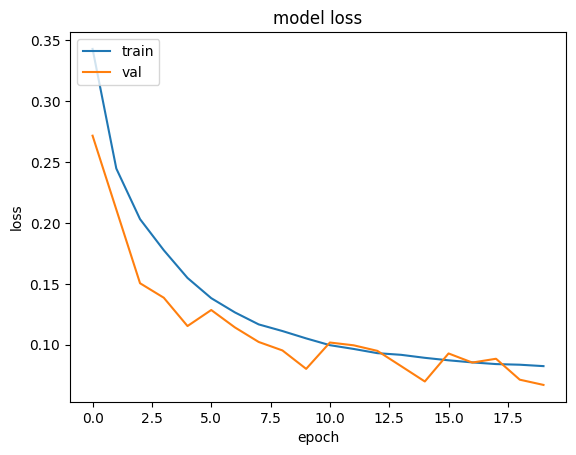

In [30]:
print(LemmatizedCbowW2VwNS.model.history.history.keys())
# summarize history for accuracy
plt.plot(LemmatizedCbowW2VwNS.model.history.history['loss'])
plt.plot(LemmatizedCbowW2VwNS.model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [31]:
embeddings = LemmatizedCbowW2VwNS.model.layers[2].get_weights()[0]

In [35]:
most_similar('любовь', lwiki, embeddings)

['любовь',
 'страсть',
 'старина',
 'бог',
 'поступок',
 'сожаление',
 'доверие',
 'ненависть',
 'уважение',
 'воспитывать']

In [45]:
most_similar('стена', lwiki, embeddings)

['стена',
 'ворота',
 'дверь',
 'проём',
 'неф',
 'фасад',
 'статуя',
 'иконостас',
 'мозаика',
 'фреска']

# Задание 2 (2 балла)

Обучите 1 word2vec и 1 fastext модель в gensim. В каждой из модели нужно задать все параметры, которые мы разбирали на семинаре. Заданные значения должны отличаться от дефолтных и от тех, что мы использовали на семинаре.

In [4]:
import gensim

In [15]:
class GensimVocab(Vocab):

    def __init__(self, corpus_path:str):

        with open(corpus_path) as file:
            texts = file.read().split('\n')

        self.texts = [self.preprocess(text) for text in texts]



In [16]:
gensim_wiki = GensimVocab(r"data/wiki_data.txt")

In [52]:
gensim_w2v = gensim.models.Word2Vec(
    gensim_wiki.texts,
    vector_size=321,
    min_count=15,
    max_vocab_size=1000000000,
    window=7,
    epochs=10
)

In [58]:
len(gensim_w2v.wv.key_to_index)

32750

In [57]:
gensim_w2v.wv.most_similar('любовь')

[('любви', 0.7611179351806641),
 ('страсть', 0.7200191020965576),
 ('уважения', 0.7165058255195618),
 ('миссис', 0.7048069834709167),
 ('богу', 0.7007331252098083),
 ('мужу', 0.7006232738494873),
 ('молодая', 0.6973824501037598),
 ('энни', 0.6760882139205933),
 ('любовью', 0.674912691116333),
 ('кураж', 0.6737788915634155)]

### Не нравится результат, пробуем еще

In [59]:
gensim_w2v = gensim.models.Word2Vec(
    gensim_wiki.texts,
    vector_size=666,
    min_count=20,
    max_vocab_size=1000000000,
    window=9,
    epochs=10
)

In [63]:
len(gensim_w2v.wv.key_to_index)

25344

In [61]:
gensim_w2v.wv.most_similar('любовь')

[('любви', 0.7644326686859131),
 ('миссис', 0.7369166612625122),
 ('молодая', 0.7276000380516052),
 ('страсть', 0.7124125957489014),
 ('мама', 0.6970254778862),
 ('чувства', 0.6925723552703857),
 ('радость', 0.6910911202430725),
 ('богу', 0.6889956593513489),
 ('вере', 0.6889660954475403),
 ('сердце', 0.6864920854568481)]

### Все еще не устраивает

In [65]:
gensim_w2v = gensim.models.Word2Vec(
    gensim_wiki.texts,
    vector_size=666,
    min_count=20,
    max_vocab_size=1000000000,
    window=9,
    epochs=10,                             
    hs=0,
    negative=15,
    sample=1e-4,
    sg=0  ##  пытался с 1, оч долго учится
)

In [66]:
len(gensim_w2v.wv.key_to_index)

25344

In [67]:
gensim_w2v.wv.most_similar('любовь')

[('любви', 0.8729708194732666),
 ('мама', 0.805396318435669),
 ('счастье', 0.7944716215133667),
 ('душой', 0.7936839461326599),
 ('возлюбленной', 0.7911733984947205),
 ('чувства', 0.7888699769973755),
 ('радость', 0.7762786149978638),
 ('вера', 0.7742260098457336),
 ('любовью', 0.7737452983856201),
 ('девушке', 0.7720531225204468)]

###  <u><b>Так-то лучше.</b></u>

#### Теперь попробуем фасттекст дефолтный и с такими же параметрами, как w2v

In [70]:
stock_gensim_ft = gensim.models.FastText(
    gensim_wiki.texts,
)

In [71]:
len(stock_gensim_ft.wv.key_to_index)

85552

In [72]:
stock_gensim_ft.wv.most_similar('любовь')

[('любовь»', 0.9752085208892822),
 ('«любовь', 0.954326331615448),
 ('любовницу', 0.9413809180259705),
 ('любовью', 0.9279448390007019),
 ('любовниц', 0.8798756003379822),
 ('любви', 0.8763165473937988),
 ('люблю', 0.8715306520462036),
 ('любэ', 0.8708557486534119),
 ('лю', 0.8708375096321106),
 ('люк', 0.8225675821304321)]

In [73]:
gensim_ft = gensim.models.Word2Vec(
    gensim_wiki.texts,
    vector_size=666,
    min_count=20,
    max_vocab_size=1000000000,
    window=9,
    epochs=10
)

In [74]:
len(gensim_ft.wv.key_to_index)

25344

In [75]:
gensim_ft.wv.most_similar('любовь')

[('любви', 0.7707892656326294),
 ('миссис', 0.72881019115448),
 ('мама', 0.7225119471549988),
 ('молодая', 0.7186397910118103),
 ('чувства', 0.7150588035583496),
 ('надежду', 0.6914793848991394),
 ('любовью', 0.6910414099693298),
 ('чарли', 0.6909416317939758),
 ('нина', 0.6892678141593933),
 ('девочка', 0.6823583245277405)]

####  И на скипграммах одну ради приличия

In [76]:
sg_gensim_ft = gensim.models.FastText(
    gensim_wiki.texts,
    sg=1
)

In [77]:
len(sg_gensim_ft.wv.key_to_index)

85552

In [78]:
sg_gensim_ft.wv.most_similar('любовь')

[('любовь»', 0.9327369332313538),
 ('«любовь', 0.917993426322937),
 ('любовью', 0.8782020807266235),
 ('любовница', 0.8601531386375427),
 ('любви', 0.8456097841262817),
 ('любимая', 0.8011912107467651),
 ('любэ', 0.7984287142753601),
 ('любовницу', 0.7908124327659607),
 ('любишь', 0.7775978446006775),
 ('любовниц', 0.776543140411377)]

# Задание 3 (3 балла)

Используя датасет для классификации (labeled.csv), обучите классификатор на базе эмбеддингов. Оцените качество на отложенной выборке.   
В качестве эмбеддинг модели вы можете использовать одну из моделей обученных в предыдущем задании или использовать одну из предобученных моделей с rusvectores (удостоверьтесь что правильно воспроизводите предобработку в этом случае!)  
Для того, чтобы построить эмбединг целого текста, усредните вектора отдельных слов в один общий вектор. 
В качестве алгоритма классификации используйте LogisicticRegression (можете попробовать SGDClassifier, чтобы было побыстрее)  
F1 мера должна быть выше 20%. 

#### Кажется, что для решения этой задачи можно попробовать word2vec и на леммах тоже тк тексты маленькие 

In [85]:
class LemmatizedGensimVocab(LemmatizedVocab):

    def __init__(self, corpus_path:str):

        self.itercounter = 0
        self.totalcounter = 0

        with open(corpus_path) as file:
            texts = file.read().split('\n')

        self.texts = [self.preprocess(text) for text in texts]

In [87]:
gensim_lwiki = LemmatizedGensimVocab(r"data/wiki_data.txt")

1000/20000
2000/20000
3000/20000
4000/20000
5000/20000
6000/20000
7000/20000
8000/20000
9000/20000
10000/20000
11000/20000
12000/20000
13000/20000
14000/20000
15000/20000
16000/20000
17000/20000
18000/20000
19000/20000
20000/20000


In [88]:
l_gensim_w2v = gensim.models.Word2Vec(
    gensim_lwiki.texts,
    vector_size=666,
    min_count=20,
    max_vocab_size=1000000000,
    window=9,
    epochs=10,                             
    hs=0,
    negative=15,
    sample=1e-4,
    sg=0  ##  пытался с 1, оч долго учится
)

In [89]:
len(l_gensim_w2v.wv.key_to_index)

17222

In [90]:
l_gensim_w2v.wv.most_similar('любовь')

[('чувство', 0.787438154220581),
 ('счастие', 0.7733960747718811),
 ('страсть', 0.772852897644043),
 ('добрый', 0.7474283576011658),
 ('радость', 0.7422782778739929),
 ('красота', 0.7390154600143433),
 ('восхищение', 0.737478494644165),
 ('любящий', 0.7254791855812073),
 ('преданность', 0.7235020399093628),
 ('влюбить', 0.7133684158325195)]

#### Теперь загрузим датасет и выдумаем классификатор

In [91]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

import pandas as pd

In [93]:
labeled = pd.read_csv(r"data/labeled.csv")

TRAIN, TEST = train_test_split(labeled, test_size=0.1, shuffle=True, random_state=666)
TRAIN.reset_index(inplace=True)
TEST.reset_index(inplace=True)

In [103]:
TRAIN["comment"].values[0]

'Лучше бы вам pgn 300 выписали, сами поразитесь какой вы болтливый.)\n'

In [138]:
class ToxicClassifier:

    def __init__(self, vectorizer: gensim.models.Word2Vec, vocab: Vocab):
        self.vectorizer = vectorizer
        self.vocab = vocab

        # Такая модель показала лучшие результаты в дз2
        self.classifier = LogisticRegression(
            solver ="liblinear",
            penalty="l2"       ,
        )

        X = [
            self.text_to_vector(comment)
            for comment
            in TRAIN["comment"].values
        ]
        y = TRAIN["toxic"].values

        self.classifier.fit(X, y)
            
    def text_to_vector(self, text):
        tokens = self.vocab.preprocess(text)
        vector = np.zeros(self.vectorizer.vector_size)
        count = 0
        for token in tokens:
            if token in self.vectorizer.wv:
                vector += self.vectorizer.wv[token]
                count += 1
        if count > 0:
            vector /= count
        return vector
    
    def get_preds(self, texts, verbose=False):
        X = [
            self.text_to_vector(text)
            for text
            in texts
        ]
        preds = self.classifier.predict(X)

        if verbose:
            preds = [
                ("OK", "Toxic")[int(pred)]
                for pred
                in preds
            ]

        return preds

In [139]:
toxic_classifier_stock_w2v = ToxicClassifier(
    gensim_w2v,
    gensim_wiki,
)

In [140]:
toxic_classifier_stock_w2v.get_preds(
    ["Люди всё время меня спрашивают: знаю ли я Тайлера Дёрдена?"],
    verbose=True
)

['OK']

In [141]:
toxic_classifier_stock_w2v.get_preds(
    ["Как же я ненавижу австралийцев"],
    verbose=True
)

['Toxic']

In [142]:
print(
    classification_report(
        TEST["toxic"].values,
        toxic_classifier_stock_w2v.get_preds(
            TEST["comment"].values
        ),
        zero_division=0
    )
)

              precision    recall  f1-score   support

         0.0       0.82      0.89      0.85       980
         1.0       0.72      0.57      0.64       462

    accuracy                           0.79      1442
   macro avg       0.77      0.73      0.75      1442
weighted avg       0.79      0.79      0.78      1442



In [143]:
# упс, не убрал отладку в препроце
toxic_classifier_l_w2v = ToxicClassifier(
    l_gensim_w2v,
    gensim_lwiki,
)

21000/20000
22000/20000
23000/20000
24000/20000
25000/20000
26000/20000
27000/20000
28000/20000
29000/20000
30000/20000
31000/20000
32000/20000


In [148]:
toxic_classifier_l_w2v.get_preds(
    ["Люди всё время меня спрашивают: знаю ли я Тайлера Дёрдена?"],
    verbose=True
)

['OK']

In [149]:
toxic_classifier_l_w2v.get_preds(
    ["Как же я ненавижу австралийцев"],
    verbose=True
)

['Toxic']

In [150]:
print(
    classification_report(
        TEST["toxic"],
        toxic_classifier_l_w2v.get_preds(
            TEST["comment"]
        ),
        zero_division=0
    )
)

36000/20000
37000/20000
              precision    recall  f1-score   support

         0.0       0.84      0.91      0.87       980
         1.0       0.77      0.63      0.69       462

    accuracy                           0.82      1442
   macro avg       0.80      0.77      0.78      1442
weighted avg       0.82      0.82      0.82      1442



#### Как и ожидалось, с лемматизацией лучше

# Задание 4 (2 доп балла)

В тетрадку с фастекстом добавьте код для обучения с negative sampling (задача сводится к бинарной классификации) и обучите модель. Проверьте полученную модель на нескольких словах. Похожие слова должны быть похожими по смыслу и по форме.

In [2]:
wiki = open('data/wiki_data.txt').read().split('\n')

In [3]:
import re
from collections import Counter
def tokenize(text):
    tokens = re.sub('#+', ' ', text.lower()).split()
    tokens = [token.strip(punctuation) for token in tokens]
    tokens = [token for token in tokens if token]
    return tokens


In [4]:
def ngrammer(raw_string, n=2):
    ngrams = []
    raw_string = ''.join(['<', raw_string, '>'])
    for i in range(0,len(raw_string)-n+1):
        ngram = ''.join(raw_string[i:i+n])
        if ngram == '<' or ngram == '>': # сами по себе <> как токены не нужны
            continue
        ngrams.append(ngram)
    return ngrams

In [5]:
def split_tokens(tokens, min_ngram_size, max_ngram_size):
    tokens_with_subwords = []
    for token in tokens:
        subtokens = []
        for i in range(min_ngram_size, max_ngram_size+1):
            if len(token) > i:
                subtokens.extend(ngrammer(token, i))
        tokens_with_subwords.append(subtokens)
    return tokens_with_subwords

In [6]:
class SubwordTokenizer:
    def __init__(self, ngram_range=(1,1), min_count=5):
        self.min_ngram_size, self.max_ngram_size = ngram_range
        self.min_count = min_count
        self.subword_vocab = None
        self.fullword_vocab = None
        self.vocab = None
        self.id2word = None
        self.word2id = None

    def build_vocab(self, texts):
        # чтобы построить словарь нужно пройти по всему корпусу и собрать частоты всех уникальных слов и нграммов
        unfiltered_subword_vocab = Counter()
        unfiltered_fullword_vocab = Counter()
        for text in texts:
            tokens = tokenize(text)
            unfiltered_fullword_vocab.update(tokens)
            subwords_per_token = split_tokens(tokens, self.min_ngram_size, self.max_ngram_size)
            for subwords in subwords_per_token:
                # в одном слове могут быть одинаковые нграммы поэтому возьмем только уникальные
                unfiltered_subword_vocab.update(set(subwords))

        self.fullword_vocab = set()
        self.subword_vocab = set()

        # теперь отфильтруем по частоте
        for word, count in unfiltered_fullword_vocab.items():
            if count >= self.min_count:
                self.fullword_vocab.add(word)
        # для нграммов сделаем порог побольше чтобы не создавать слишком много нграммов
        # и учитывать только действительно частотные
        for word, count in unfiltered_subword_vocab.items():
            if count >= (self.min_count * 100):
                self.subword_vocab.add(word)

        # общий словарь
        self.vocab = self.fullword_vocab | self.subword_vocab
        self.id2word = {i:word for i,word in enumerate(self.vocab)}
        self.word2id = {word:i for i,word in self.id2word.items()}

    def subword_tokenize(self, text):
        if self.vocab is None:
            raise AttributeError('Vocabulary is not built!')
        # разбиваем на токены
        tokens = tokenize(text) 
        # каждый токен разбиваем на символьные нграммы
        tokens_with_subwords = split_tokens(tokens, self.min_ngram_size, self.max_ngram_size)
        # оставляет только токены и нграммы которые есть в словаре
        only_vocab_tokens_with_subwords = []
        for full_token, sub_tokens in zip(tokens, tokens_with_subwords):
            filtered = []
            if full_token in self.vocab:
                # само слово и нграммы хранятся в одном списке 
                # но слово будет всегда первым в списке
                filtered.append(full_token)
            filtered.extend([subtoken for subtoken in set(sub_tokens) if subtoken in self.vocab])
            only_vocab_tokens_with_subwords.append(filtered)

        return only_vocab_tokens_with_subwords

    def encode(self, subword_tokenized_text):
        # маппим токены и нграммы в их индексы в словаре
        encoded_text = []
        for token in subword_tokenized_text:
            if not token:
                continue
            encoded_text.append([self.word2id[token[0]]] + [self.word2id[t] for t in set(token[1:]) if t in self.word2id and t != token[0]])
        return encoded_text

    def __call__(self, text):
        return self.encode(self.subword_tokenize(text))

In [7]:
tokenizer = SubwordTokenizer(ngram_range=(2,4), min_count=10)

In [12]:
tokenizer.build_vocab(wiki)

In [16]:
def gen_batches_ft_ns(sentences, tokenizer:SubwordTokenizer, window = 5, batch_size=1000, maxlen=20):
    
    
    left_context_length = (window/2).__ceil__() 
    right_context_length = window // 2 

    vocab_size= len(tokenizer.vocab)
    
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            sent = tokenizer(sent)

            for i in range(len(sent)-1):
                word_with_subtokens = sent[i]
                context = sent[max(0, i-left_context_length):i] + sent[i+1:i+right_context_length]
                for context_word_with_subtokens in context:

                    only_full_word_context_token = context_word_with_subtokens[0]

                    X_target.append(word_with_subtokens)
                    X_context.append(only_full_word_context_token)
                    y.append(1)
                    
                    X_target.append(word_with_subtokens)
                    X_context.append(np.random.randint(vocab_size))
                    y.append(0)
                    
                    if len(X_target) >= batch_size*2:
                        X_target  = np.array(keras.preprocessing.sequence.pad_sequences(X_target , maxlen=maxlen))
                        X_context = np.array(X_context)
                        y = np.array(y)
                        yield ((X_target, X_context), y)
                        X_target  = []
                        X_context = []
                        y = []

In [17]:
gen = gen_batches_ft_ns(wiki, tokenizer, batch_size=5)

In [18]:
next(gen)

((array([[16687,  7662, 51318, 51700, 32398, 37695,  5846, 47583, 43335,
          46355, 17927, 24683, 26257, 14499, 16236, 50899,  9555, 25997,
          43134, 30033],
         [16687,  7662, 51318, 51700, 32398, 37695,  5846, 47583, 43335,
          46355, 17927, 24683, 26257, 14499, 16236, 50899,  9555, 25997,
          43134, 30033],
         [34194, 47311, 45587, 16124, 27008, 40705, 32190,  8502, 12028,
           5145, 38760, 18456,  3015, 41781, 18892, 22273,  9985,  6155,
          50181, 43134],
         [34194, 47311, 45587, 16124, 27008, 40705, 32190,  8502, 12028,
           5145, 38760, 18456,  3015, 41781, 18892, 22273,  9985,  6155,
          50181, 43134],
         [34194, 47311, 45587, 16124, 27008, 40705, 32190,  8502, 12028,
           5145, 38760, 18456,  3015, 41781, 18892, 22273,  9985,  6155,
          50181, 43134],
         [34194, 47311, 45587, 16124, 27008, 40705, 32190,  8502, 12028,
           5145, 38760, 18456,  3015, 41781, 18892, 22273,  9985,  6155,

In [19]:
class FasttextNS:
    inputs_target  = keras.layers.Input(shape=(20,)) 
    inputs_context = keras.layers.Input(shape=(1,)) 

    embeddings_target  = keras.layers.Embedding(input_dim=len(tokenizer.vocab), output_dim=100)(inputs_target)
    embeddings_context = keras.layers.Embedding(input_dim=len(tokenizer.vocab), output_dim=100)(inputs_context)

    target  = keras.layers.Lambda(lambda x: x.mean(axis=1))(embeddings_target)
    context = keras.layers.Lambda(lambda x: x.mean(axis=1))(embeddings_context)

    dot = keras.layers.Dot(1)([target, context])
    outputs = keras.layers.Activation(activation='sigmoid')(dot)

    model = keras.Model(inputs=[inputs_target, inputs_context], outputs=outputs)

    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
    model.build((None, 10))

In [20]:
FasttextNS.model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 20, 100)   │  5,486,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 100)    │  5,486,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 100)       │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 100)       │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 1)         │          0 │ lambda[0][0],     │
│                     │                   │            │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ dot[0][0]         │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,972,000 (41.85 MB)

 Trainable params: 10,972,000 (41.85 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
FasttextNS.model.fit(
    gen_batches_ft_ns(wiki[:19000],tokenizer, window=5, batch_size=100),
    validation_data=gen_batches_ft_ns(wiki[19000:], tokenizer, window=5, batch_size=100),
    batch_size=2000,
    steps_per_epoch=10000,
    validation_steps=100,
    epochs=10
)

Epoch 1/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 97s 10ms/step - accuracy: 0.7709 - loss: 0.4792 - val_accuracy: 0.7991 - val_loss: 0.4565
Epoch 2/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 98s 10ms/step - accuracy: 0.8176 - loss: 0.4099 - val_accuracy: 0.8072 - val_loss: 0.4343
Epoch 3/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 99s 10ms/step - accuracy: 0.8300 - loss: 0.3874 - val_accuracy: 0.8154 - val_loss: 0.4090
Epoch 4/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 99s 10ms/step - accuracy: 0.8203 - loss: 0.4069 - val_accuracy: 0.8263 - val_loss: 0.3977
Epoch 5/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 97s 10ms/step - accuracy: 0.8202 - loss: 0.4032 - val_accuracy: 0.8128 - val_loss: 0.4252
Epoch 6/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 99s 10ms/step - accuracy: 0.8320 - loss: 0.3836 - val_accuracy: 0.8288 - val_loss: 0.3919
Epoch 7/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 102s 10ms/step - accuracy: 0.8243 - loss: 0.3969 - val_accuracy: 0.8108 - val_loss: 0.4167
Epoch 8/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 103s 10ms/step - 

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


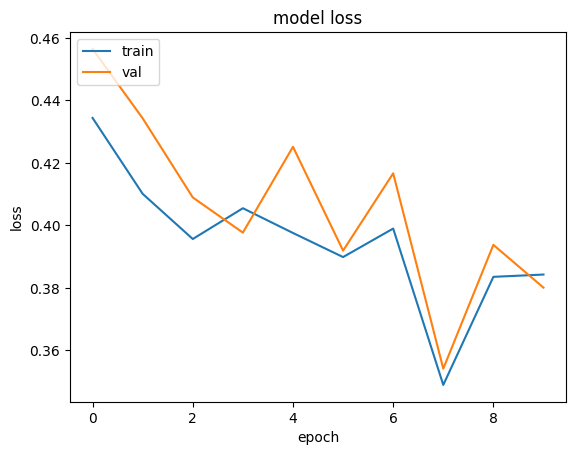

In [22]:
print(FasttextNS.model.history.history.keys())
# summarize history for accuracy
plt.plot(FasttextNS.model.history.history['loss'])
plt.plot(FasttextNS.model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [35]:
embeddings = FasttextNS.model.layers[3].get_weights()[0] # матрица со всеми эмбедингами

In [36]:
FasttextNS.model.layers

[<InputLayer name=input_layer, built=True>,
 <InputLayer name=input_layer_1, built=True>,
 <Embedding name=embedding, built=True>,
 <Embedding name=embedding_1, built=True>,
 <Lambda name=lambda, built=True>,
 <Lambda name=lambda_1, built=True>,
 <Dot name=dot, built=True>,
 <Activation name=activation, built=True>]

In [37]:
full_word_embeddings = np.zeros((len(tokenizer.fullword_vocab), 100)) # матрица с эмбедингами полных слов + нграммы
id2word = list(tokenizer.fullword_vocab)

for i, word in enumerate(tokenizer.fullword_vocab):
    subwords = tokenizer(word)[0]
    full_word_embeddings[i] = embeddings[[i for i in subwords]].mean(axis=0) 

In [38]:
def most_similar_ft(word, embeddings, tokenizer):
    subwords = tokenizer(word)[0]
    word_embedding = embeddings[[i for i in subwords]].sum(axis=0)
    # idxs = [tokenizer.word2id[i] for i in tokenizer.fullword_vocab]
    similar = [id2word[i] for i in 
               cosine_distances(word_embedding.reshape(1, -1), full_word_embeddings).argsort()[0][:20]]
    return similar

In [39]:
most_similar_ft('любовь', embeddings, tokenizer)

['любовь',
 'любовная',
 'любовью',
 'любовных',
 'любовницей',
 'любовница',
 'любовной',
 'любительскую',
 'любовные',
 'любовь»',
 'любить',
 'любительские',
 'любителем',
 'впечатлением',
 'любительского',
 'любовницы',
 '«академия',
 'любовник',
 'любовника',
 'связывающая']